In [2]:
import torch
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim


# GANs 

https://github.com/himansharma21/GAN


In this assignment we are going to train a GAN on a dataset of Monet images. 

We have 300 Monet images.

In [7]:
monet_dir = 'Data/monet_jpg'

image_files = os.listdir(monet_dir)

print(f"Number of Monet Images: {len(image_files)}")


Number of Monet Images: 300


### Data Loading 

We're going to use a simple Dataset to load the images. This is going to make the training and testing process simpler. We will also need be able to transform the data as we need. 


In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname) 
                            for fname in os.listdir(image_dir) 
                            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image

        except Exception as e:
            print(f"Warning: Skipping corrupted image at {img_path}. Reason: {e}")

            # Return a dummy black image to maintain batch consistency
            dummy_image = torch.zeros(3, 64, 64)  # Assuming your transforms resize to 64x64
            return dummy_image

In [9]:
from torch.utils.data import DataLoader


transform = transforms.Compose([])
dataset = ImageDataset(image_dir=monet_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

### EDA 

### Image Overview 
The Monet images are of size 256x256. This is very large for our use case, we will later resize the images to make it easier to train.

Image size: 256x256


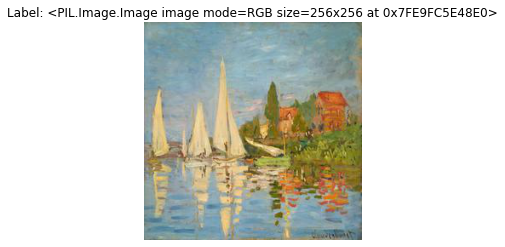

In [10]:
img = dataset[0]

print("Image size: {}x{}".format(img.width,img.height))


plt.imshow(img)
plt.title(f"Label: {img}")
plt.axis('off')
plt.show()

### Image Dimensions 

We need all images to be the same size for training.Therefore we're also going to go over each image and confirm that they're all the same size. 

In [11]:
sizes = []
first_image = dataset[0]

first_width = first_image.width
first_height = first_image.height

for image in dataset:
  assert(image.width == first_width)
  assert(image.height == first_height)


print("All images are the same size")

All images are the same size


### Image Channels

Images can be encoded in a variety of different ways. This can change the number of channels they have, which we need to know in order to build our model. 

Also we can see that our images are in the RGB space, meaning 3 channels. 

In [12]:
print(f"Image mode: {img.mode}")

Image mode: RGB


### Model Architecture

We're going to deploy a simple GAN made of two small neural networks. A **Generator**, and a **Discriminator**. Both models are intentionally kept lightweight to make training easier and faster, especially when working with relatively small 64×64 pixel images.

---

### Generator

The **Generator** takes a random noise vector and transforms it into a 64×64 RGB image.

Its structure is:

- A **Linear** layer that maps the input to 256 dimensions.
- A **ReLU** activation to introduce non-linearity.
- Another **Linear** layer that expands the 256 features to match the flattened size of a 64×64×3 image.
- A **Tanh** activation, which squashes the pixel values into the range [-1, 1]. This is standard practice for GANs.

Finally, the output vector is reshaped into the familiar (3, 64, 64) image format.


This generator is very minimal. For simple datasets or basic experiments, this makes the generator quick to train.


### Discriminator

The **Discriminator** is built to take an image and output a single scalar between 0 and 1, representing the probability that the input image is *real* rather than *fake*.

Its structure is:

- A **Flatten** layer that converts the 3D image into a 1D vector.
- A **Linear** layer reducing the flattened image down to 256 features.
- A **LeakyReLU** activation
- A final **Linear** layer mapping down to 1 output.
- A **Sigmoid** activation to produce a probability.


Just like the generator, the discriminator is lightweight. It uses basic linear layers, which are enough when working with relatively low-complexity image generation tasks. 

In [13]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 64 * 64 * img_channels),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 3, 64, 64)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * img_channels, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [16]:
device = torch.device("cpu")
batch_size = 128
learning_rate = 0.0002
noise_dim = 100
num_epochs = 10
sample_dir = "generated_samples"

os.makedirs(sample_dir, exist_ok=True)


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageDataset(image_dir=monet_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)


generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)


criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

### Training Loop Overview

The training loop follows a standard GAN procedure:

- **For each epoch:**
  - Loop over the real images from the dataset.
  - Train the Generator (G):
    - Generate fake images from random noise.
    - Compute the generator loss by trying to fool the discriminator
    - Backpropagate and update the generator.
  - Train the Discriminator (D):
    - Calculate the discriminator loss on real images and on fake images.
    - Backpropagate and update the discriminator.

- After each epoch:
  - Print the current generator and discriminator losses.
  - Save a grid of generated images for visual inspection.

In [18]:
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os

def run_training_loop():
    for epoch in range(num_epochs):
        for i, real_imgs in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # Train gen
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, noise_dim, device=device)
            gen_imgs = generator(z)

            g_loss = criterion(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()


            # Train dis
            optimizer_D.zero_grad()

            real_loss = criterion(discriminator(real_imgs), valid)
            fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}]" f"Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")


        with torch.no_grad():
            fake_imgs = generator(torch.randn(64, noise_dim, device=device)).detach().cpu()
            save_image(fake_imgs, os.path.join(sample_dir, f"epoch_{epoch+1}.png"), normalize=True, nrow=8)

run_training_loop()

Epoch [0/10]Loss D: 0.6708, Loss G: 0.6925
Epoch [1/10]Loss D: 0.2541, Loss G: 1.4532
Epoch [2/10]Loss D: 0.1395, Loss G: 2.3760
Epoch [3/10]Loss D: 0.0809, Loss G: 2.9602
Epoch [4/10]Loss D: 0.0629, Loss G: 3.1297
Epoch [5/10]Loss D: 0.0586, Loss G: 3.0163
Epoch [6/10]Loss D: 0.0724, Loss G: 2.4637
Epoch [7/10]Loss D: 0.1174, Loss G: 1.7783
Epoch [8/10]Loss D: 0.1754, Loss G: 1.2751
Epoch [9/10]Loss D: 0.2243, Loss G: 1.0883


### Training Loss

As observed above, the discriminator's training loss steadily decreases. Meanwhile, the generator's loss exhibits oscillations, which suggests that the learning rate may be set too high.


What would happen if we increased the learning rate even further?


In [25]:
learning_rate = 0.002
num_epochs = 10

run_training_loop()

Epoch [0/10]Loss D: 0.0459, Loss G: 3.0725
Epoch [1/10]Loss D: 0.0950, Loss G: 2.8091
Epoch [2/10]Loss D: 0.0860, Loss G: 2.8241
Epoch [3/10]Loss D: 0.0529, Loss G: 3.5016
Epoch [4/10]Loss D: 0.1223, Loss G: 3.0609
Epoch [5/10]Loss D: 0.1333, Loss G: 2.8372
Epoch [6/10]Loss D: 0.1141, Loss G: 3.3067
Epoch [7/10]Loss D: 0.1090, Loss G: 3.4932
Epoch [8/10]Loss D: 0.0806, Loss G: 3.3669
Epoch [9/10]Loss D: 0.0733, Loss G: 3.2897


We now observe that the discriminator is also having difficulty converging.  
In fact, both the generator and discriminator losses appear to oscillate, which makes sense given the adversarial nature of GANs, with each model is continuously trying to outcompete the other.